# Police brutality events in the 2020 protests after George Floyd's death

This [repo](https://github.com/2020PB/police-brutality) is crowd-collecting (and verifying) incidents of police applying excessive force towards protesters in the 2020 demonstrations after George Floyd's death. The incidents are registered by people and committed with links to videos (usually twitter). Repo has a REST API which we are pinging here to get the data.

In [30]:
import requests
import pandas as pd
from datetime import datetime

from matplotlib import pyplot as plt
import matplotlib

import spacy
import gensim

import json

import collections

%matplotlib inline

In [37]:
# Get the incidede

r = requests.get("https://api.846policebrutality.com/api/incidents")

In [38]:
r.status_code

200

In [39]:
data = r.json()['data']

In [40]:
len(data)

369

In [41]:
data[0]

{'id': '09cd8690-ace0-11ea-8984-cff4810dd459',
 'pb_id': 'mn-minneapolis-23',
 'state': 'Minnesota',
 'city': 'Minneapolis',
 'date': '2020-05-30T00:00:00.000000Z',
 'title': 'CBS crew fired upon by police.',
 'description': None,
 'links': ['https://twitter.com/MikeGeorgeCBS/status/1267087091122528256',
  'https://twitter.com/MikeGeorgeCBS/status/1266919447970942986',
  'https://twitter.com/MikeGeorgeCBS/status/1266916104951214080'],
 'data': None,
 'geocoding': {'lat': '44.9777530', 'long': '-93.2650108'}}

In [42]:
# dump data to file in case can't query it anymore

json.dump(data, open('georgefloyd_protests_incidents.json', 'w'))

In [43]:
min([item['date'] for item in data])

'1900-01-01T00:00:00.000000Z'

## Get into a dataframe

Only use data we want to use.

In [44]:
df = pd.DataFrame(
    {'id': [item['id'] for item in data],
     'state': [item['state'] for item in data],
     'city': [item['city'] for item in data],
     'date': [item['date'] for item in data],
     'title': [item['title'] for item in data]
    }
)

# sort the date info
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df.head()

,id,state,city,date,title
0,09cd8690-ace0-11ea-8984-cff4810dd459,Minnesota,Minneapolis,2020-05-30 00:00:00+00:00,CBS crew fired upon by police.
1,1bc81b90-ad1c-11ea-9e54-7933512bebd5,Minnesota,Minneapolis,2020-05-26 00:00:00+00:00,Man has his gun confiscated in an open carry s...
2,22035e90-b0d5-11ea-b535-bf95ae94d6bf,Virginia,Richmond,2020-06-13 00:00:00+00:00,"Police SUV pushes through protesters, knocks o..."
3,22149840-b0d5-11ea-86dc-251707a21e5b,California,Hollywood,2020-06-02 00:00:00+00:00,Police fire into a crowd of peaceful protester...
4,26e447b0-af46-11ea-b93f-392636229177,Oregon,Portland,2020-06-08 00:00:00+00:00,Officer forces press away from protest


In [45]:
tmp.sort_values('date')

,date,id,state,city,title
0,1900-01-01 00:00:00+00:00,10,10,10,10
1,2020-05-26 00:00:00+00:00,3,3,3,3
2,2020-05-28 00:00:00+00:00,1,1,1,1
3,2020-05-29 00:00:00+00:00,25,25,25,25
4,2020-05-30 00:00:00+00:00,79,79,79,79
5,2020-05-31 00:00:00+00:00,111,111,111,111
6,2020-06-01 00:00:00+00:00,52,52,52,52
7,2020-06-02 00:00:00+00:00,30,30,30,30
8,2020-06-03 00:00:00+00:00,20,20,20,20
9,2020-06-04 00:00:00+00:00,14,14,14,14


## Incidents in time

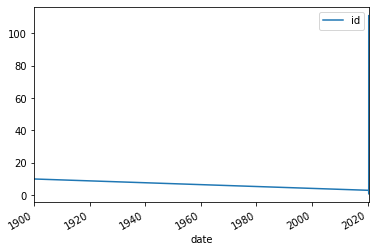

In [46]:
tmp = df.groupby('date').count().reset_index()

tmp.sort_values('date').plot('date', 'id')

plt.show();

## words 

Looking at words from the titles given to the incidents

In [47]:
len(data)

369

In [104]:
doc = nlp("I am much better than you and I write a lot")

for token in doc:
        print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
              token.shape_, token.is_alpha, token.is_stop)

I -PRON- PRON PRP nsubj X True True
am be AUX VBP ROOT xx True True
much much ADV RB advmod xxxx True True
better well ADJ JJR acomp xxxx True False
than than SCONJ IN prep xxxx True True
you -PRON- PRON PRP pobj xxx True True
and and CCONJ CC cc xxx True True
I -PRON- PRON PRP nsubj X True True
write write VERB VBP ROOT xxxx True False
a a DET DT det x True True
lot lot NOUN NN dobj xxx True False


In [105]:
# polish the title a bit (remove -, as in "pepper-spray"; remove /)
# then
# get adjectives and nouns only from each title - use spacy,get vrbs as well (need "arrest")
# then add to data, lowering case

nlp = spacy.load("en_core_web_sm")

for item in data:
    title = item['title']
    title = title.replace('-', ' ').replace('/', ' ')
    item['pos'] = []
    doc = nlp(title)
    #print(title)
    for token in doc:
#         print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#               token.shape_, token.is_alpha, token.is_stop)
        if token.pos_ in ('NOUN', 'ADJ', 'VERB'):
            item['pos'].append((token.lemma_.lower(), token.pos_))

In [106]:
# for item in data:
#     print(item['title'], item['pos'])

In [107]:
# look at frequencies

all_words = []
for item in data:
    for word in item['pos']:
        all_words.append(word[0])
#c = collections.counter()

all_words[:10]
len(all_words)

2087

In [108]:
c = collections.Counter(all_words)

In [140]:
c.most_common()[260:280]

[('number', 1),
 ('eyewitness', 1),
 ('time', 1),
 ('interview', 1),
 ('elderly', 1),
 ('cause', 1),
 ('identify', 1),
 ('induce', 1),
 ('seizure', 1),
 ('door', 1),
 ('member', 1),
 ('guy', 1),
 ('fence', 1),
 ('trash', 1),
 ('bin', 1),
 ('huffpost', 1),
 ('high', 1),
 ('rank', 1),
 ('nypd', 1),
 ('plastic', 1)]

In [137]:
# manual checks

for item in data:
    #if 'gas' in item['title'].lower() and 'tear' not in item['title'].lower():
    #if 'rubber' in item['title'] and 'bullet' not in item['title']:
    #if 'protestor' in item['title'].lower() or 'protester' in item['title']:
    if 'kick' in item['title'].lower():
        print(item['title'])
        
    

Police officer maces woman and kicks her in the head


In [ ]:
# METHODS used

# gas (tear gas) - 61
# pepper (pepper spray/pepper bullets/pepper bomb)- 47 + 3 (pepperspray) = 50
# rubber (rubber bullet) - 33
# baton - 15
# flashbang - 10
# stinger grenade - 1


# ACTIONS - shoot and fire excluded as they're encompassed in the methods (e.g., "fire bullets")

# arrest & detain - 32 & 4 = 36
# punch - 7
# choke - 2
# kick - 1

In [ ]:
# TARGETS

# reporter & journalise - 30 & 5 + 1 (photojournalist) + 1 (cameraman) = 36
# protestor  - 78 + 64 (protestor) = 142

In [ ]:
# BODY PARTS TARGETED (somehow, note this includes the "knee on neck")

# neck - 9 
# face - 14
# head - 13